# Objective - Construct a model to predict current market value of homes

### I have followed these steps to approach the problem in an systematic manner-
1. Exploratory Data Analysis - Check data types, missing values, numerical features, distribution of numerical features, categorical features, cardinality of categorical features, outliers, relationship between dependent and independent variable
2. Feature Engineering
3. Feature Selection
4. Model Building
5. Predicting home prices

### I have considered following assumptions while solving this problem - 
1. The information about only a single block group is provided within the King County
2. There is no information about the blocks within the given block group. If information about blocks would have been provided I would have imputed my missing values(BGMedRent, BGMedHomeValue) by grouping them with blocks.
3. Assuming the decimal values of bathroom and bedroom count as valid numbers
4. Homes are not remodeled after building

In the end, I have also discussed potential improvements and next steps.

# Loading required libraries and packages

In [1]:
# data processing
import numpy as np
import pandas as pd 

# data visualization
import matplotlib.style as style 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# feature engineering, feature selection, model building and evaluation
from datetime import datetime
from scipy.stats import skew 
from sklearn.utils import shuffle
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel 
from sklearn.linear_model import LinearRegression
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score

import os
import warnings
warnings.filterwarnings('ignore')

In [7]:
# Load the training data
data = pd.read_csv("Data Science ZExercise_TRAINING_CONFIDENTIAL1.csv")

# First few record of the data
data.head()

,PropertyID,SaleDollarCnt,TransDate,censusblockgroup,ZoneCodeCounty,Usecode,BedroomCnt,BathroomCnt,FinishedSquareFeet,GarageSquareFeet,...,Latitude,Longitude,BGMedHomeValue,BGMedRent,BGMedYearBuilt,BGPctOwn,BGPctVacant,BGMedIncome,BGPctKids,BGMedAge
0,48648941,285000.0,5/23/2015,5.300000e+11,R7,9,4.0,2.00,1900.0,480.0,...,47321389,-122213716,107800.0,844.0,1975.0,0.6685,0.0780,42854,0.1924,48.6
1,48648982,309950.0,8/22/2015,5.300000e+11,R8P,9,3.0,2.00,2170.0,320.0,...,47482082,-122244269,181500.0,925.0,1969.0,0.5753,0.0192,54013,0.3718,42.6
2,48649024,476000.0,8/27/2015,5.300000e+11,SF 7200,9,4.0,1.00,2150.0,590.0,...,47561383,-122308083,344300.0,733.0,1946.0,0.6331,0.0000,56782,0.3207,40.7
3,48649040,324950.0,7/1/2015,5.300000e+11,R1,9,4.0,2.25,2560.0,NaN,...,47387929,-122279389,284200.0,900.0,1977.0,0.5456,0.0573,44200,0.3359,40.0
4,48649057,325000.0,6/20/2015,5.300000e+11,LDR,9,4.0,1.75,1720.0,NaN,...,47477068,-122263852,290100.0,802.0,1972.0,0.4267,0.0551,65282,0.1633,44.4


# Exploratory Data Analysis

In [3]:
# Shape of training data
data.shape

(11588, 24)

The training data has 11588 rows and 24 columns

In [4]:
# Overview of training data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11588 entries, 0 to 11587
Data columns (total 24 columns):
PropertyID            11588 non-null int64
SaleDollarCnt         11588 non-null float64
TransDate             11588 non-null object
censusblockgroup      11588 non-null float64
ZoneCodeCounty        11588 non-null object
Usecode               11588 non-null int64
BedroomCnt            11588 non-null float64
BathroomCnt           11588 non-null float64
FinishedSquareFeet    11588 non-null float64
GarageSquareFeet      8747 non-null float64
LotSizeSquareFeet     11588 non-null int64
StoryCnt              11588 non-null float64
BuiltYear             11588 non-null float64
ViewType              2632 non-null float64
Latitude              11588 non-null int64
Longitude             11588 non-null int64
BGMedHomeValue        11582 non-null float64
BGMedRent             8957 non-null float64
BGMedYearBuilt        11341 non-null float64
BGPctOwn              11588 non-null float64
BGPctV

I can observe that there are some missing values in some of the features. Lets dig into it.

In [5]:
# Check number of features of each data type
data.dtypes.value_counts()

float64    16
int64       6
object      2
dtype: int64

There are 16 features of type 'float64', 6 features of type 'int64' and 2 features of type 'object'.

In [1825]:
# Function to check number and percentage of missing values
def missing_values(data):
    total_missing = data.isnull().sum()[data.isnull().sum() != 0]
    percent_missing = round((data.isnull().sum().sort_values()[data.isnull().sum() != 0] / len(data)) * 100, 4)

    return pd.concat([total_missing, percent_missing], axis=1,  keys=['Total Missing Values','Percentage Missing Values'])

# Get missing values for training data
missing_features = missing_values(data)
missing_features

,Total Missing Values,Percentage Missing Values
BGMedHomeValue,6,0.052
BGMedRent,2631,22.704
BGMedYearBuilt,247,2.131
GarageSquareFeet,2841,24.517
ViewType,8956,77.287


The 'missing_values' function take the training data as input and calculates the number of missing values and percentage of missing values for those feature in the data which has any missing values.
It returns the information by concatenating the result in a dataframe.

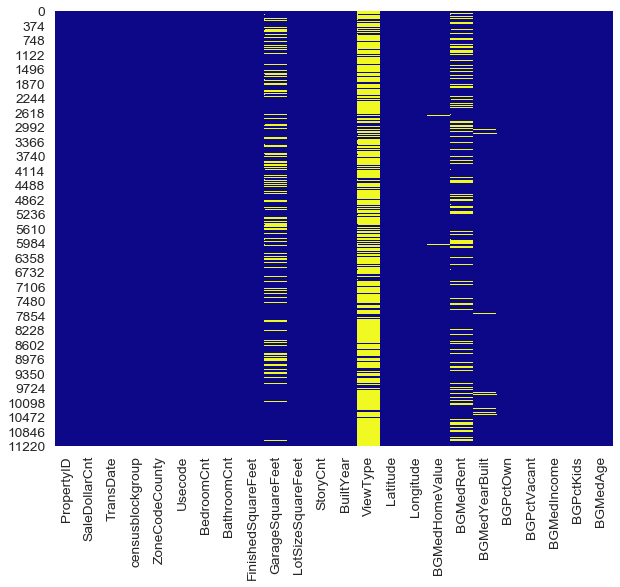

In [1826]:
# Visulaize the missing values of training data in heatmap
fig= plt.figure(figsize=(10,8))
sns.heatmap(data.isnull(), cbar=False, cmap='plasma')

Heatmap is a good way to check if there is any correlation between missing values of differnt columns.
From the visualization above, on comparing against the index I observed that -
1. GarageSquareFeet and BGMedRent has some missing values with variation in occurence
2. Most of the values in ViewType are missing(No View)
3. BGMedHomeValue and BGMedYearBuilt has only a few missing values with variation in occurence
 
There is no visbile correlation between missing values any of the any of the columns.

In [1827]:
# Check uniqueness of PropertyID column
print(data['PropertyID'].nunique())

11588


There are 11588 property ids. This is equal to the number of observations in the training data.
Thus, each home has it's unique property id.

In [1828]:
# Check for columns having a unique value i.e non-variance in the column
for feature in data.columns:
    if (len(data[feature].unique()) == 1):
        print(feature)

censusblockgroup
Usecode


There are two features that has same values throughout the training data - censusblockgroup and Usecode.

In [1829]:
# Check the values in censusblockgroup and Usecode
print('The number of values in censusblockgroup are:', len(data['censusblockgroup']))
print('The number of values in Usecode are:',len(data['Usecode']))
print('The value in censusblockgroup is:', data['censusblockgroup'].unique())
print('The value in Usecode is:', data['Usecode'].unique())

The number of values in censusblockgroup are: 11588
The number of values in Usecode are: 11588
The value in censusblockgroup is: [5.3e+11]
The value in Usecode is: [9]


I observed that columns like 'PropertyID', 'censusblockgroup' and 'Usecode' have no missing values.
'PropertyID' is unique to each observation.'censusblockgroup' and 'Usecode' have same value throughout the training data. 
Thus, these features will not provide any useful information for the prediction of home prices. It's a good idea to drop them.

In [1830]:
# Droppping 'PropertyID', 'censusblockgroup' and 'Usecode' from training data
data.drop(columns=['PropertyID', 'censusblockgroup', 'Usecode'], axis = 1, inplace = True)

In [1831]:
# Check shape of training data after dropping 'PropertyID', 'censusblockgroup' and 'Usecode'
data.shape

(11588, 21)

Now, training data contains 11588 rows and 21 columns

In [1832]:
# Convert transaction date to date type
data['TransDate'] = pd.to_datetime(data['TransDate'])

Converting 'TransDate' column to date type to extract useful information.

In [1833]:
# check values in transaction year
print('Transaction year', data['TransDate'].dt.year.astype(np.int64).unique())
print('The number of observations of transaction year is:', len(data['TransDate'].dt.year.astype(np.int64)))

Transaction year [2015]
The number of observations of transaction year is: 11588


The transaction year is same throughtout the training data and there are no missing values.

In [1834]:
# check unique values of transaction months
print('Transaction months:', data['TransDate'].dt.month.astype(np.int64).unique())

# create a new column for transaction month
data['TransMonth'] = data['TransDate'].dt.month.astype(np.int64)

Transaction months: [5 8 7 6 4 9]


There are different values of transaction month. In fact, I have the information only about transactions happened from April-September.
In the above code, I am creating a new column in the training data by extracting month of transaction from transaction date.

In [1835]:
# drop 'TransDate' column
data.drop(['TransDate'], axis=1, inplace=True)

Dropping 'TransDate' column as I have extracted the important information from that column.

In [1836]:
# check the traning data after dropping TransDate
data.head()

,SaleDollarCnt,ZoneCodeCounty,BedroomCnt,BathroomCnt,FinishedSquareFeet,GarageSquareFeet,LotSizeSquareFeet,StoryCnt,BuiltYear,ViewType,Latitude,Longitude,BGMedHomeValue,BGMedRent,BGMedYearBuilt,BGPctOwn,BGPctVacant,BGMedIncome,BGPctKids,BGMedAge,TransMonth
0,285000.000,R7,4.000,2.000,1900.000,480.000,7482,1.000,1965.000,nan,47321389,-122213716,107800.000,844.000,1975.000,0.668,0.078,42854,0.192,48.600,5
1,309950.000,R8P,3.000,2.000,2170.000,320.000,14208,1.000,1953.000,79.000,47482082,-122244269,181500.000,925.000,1969.000,0.575,0.019,54013,0.372,42.600,8
2,476000.000,SF 7200,4.000,1.000,2150.000,590.000,6500,1.000,1955.000,nan,47561383,-122308083,344300.000,733.000,1946.000,0.633,0.000,56782,0.321,40.700,8
3,324950.000,R1,4.000,2.250,2560.000,nan,15767,1.000,1962.000,79.000,47387929,-122279389,284200.000,900.000,1977.000,0.546,0.057,44200,0.336,40.000,7
4,325000.000,LDR,4.000,1.750,1720.000,nan,8620,2.000,1948.000,78.000,47477068,-122263852,290100.000,802.000,1972.000,0.427,0.055,65282,0.163,44.400,6


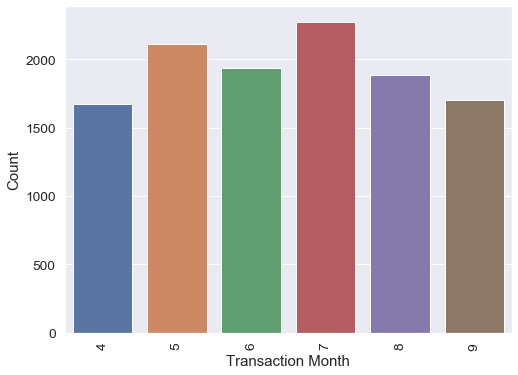

In [1837]:
# check the number of transactions in each month
fig= plt.figure(figsize=(8,6))
pt = sns.countplot(x = data['TransMonth'].sort_values() , data = data)
pt.set(xlabel='Transaction Month', ylabel='Count')
plt.xticks(range(0,  data['TransMonth'].sort_values().nunique()), data['TransMonth'].sort_values().unique() , rotation=90)
plt.show()

From the visualization, it can be observed that July had the highest number of transactions followed by May and June.

### Explore dependent variable - 'SaleDollarCnt'

In [1838]:
# check the statistics of the target value(dependent feature)
data['SaleDollarCnt'].describe()

count     11588.000
mean     613715.710
std      457759.334
min       20000.000
25%      355000.000
50%      505000.000
75%      715000.000
max     7880000.000
Name: SaleDollarCnt, dtype: float64

Some significant findings are -
1. The number of observation are 11588
2. The mean of home's price is 613715.710
3. The standard deviation of home's price is 457759.334
4. Minimum and maximum home's price are 20000.00 and 7880000.000 respectively

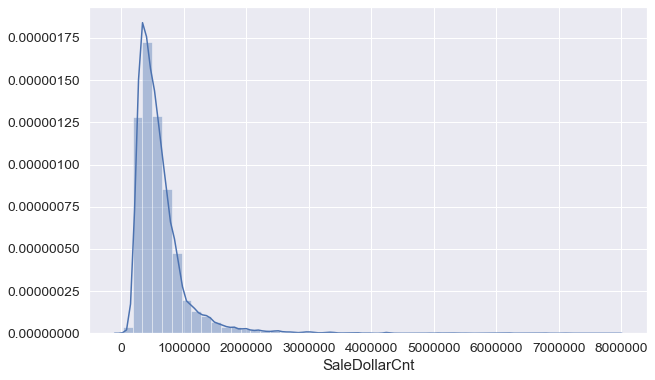

In [1839]:
# Visualizing the distribution of home price
fig= plt.figure(figsize=(10,6))
sns.distplot(data['SaleDollarCnt']);

From the visualization, it can be seen that home prices have a normal distribution with graph skewed to the right. It means that there were some homes which had a very large price as compared to others. Additionally, I observed that most of the home prices are below 1000000.
Calculating the skew and kurtosis to verify my observations.

### Since the SaleDollarCnt (target variable) is continuous and our aim is to predict it's value, this is a regression problem.

In [1840]:
#skewness and kurtosis of home prices
print("Skewness: %f" % data['SaleDollarCnt'].skew())
print("Kurtosis: %f" % data['SaleDollarCnt'].kurt())

Skewness: 4.769303
Kurtosis: 41.220569


The mesaure of skewness is 4.769303 which makes home prices are highly(positively)skewed.
The measure of kurtosis is 41.220569 which makes home prices Leptokurtic and shows that the data has a high peak and heavy tails. It indicates the presence of outliers in the home prices.

### Categorical features

In [1841]:
# Find categorical features
categorical_features = [feature for feature in data.columns if data[feature].dtypes == 'O'] 

# number of categorical features
print('Number of categorical features are:', len(categorical_features))

# Check values of categorical features
data[categorical_features].head()

Number of categorical features are: 1


,ZoneCodeCounty
0,R7
1,R8P
2,SF 7200
3,R1
4,LDR


There is only one categorical feature i.e 'ZoneCodeCounty' which represents the density the lot is legally allowed to be built-up to

In [1842]:
# check cardinality of 'ZoneCodeCounty'
print("Cardinality of zones are:", data[categorical_features].nunique())

Cardinality of zones are: ZoneCodeCounty    178
dtype: int64


There are 178 different zone codes present in the training data. Since, it is the categorical feature, I will do its label encoding in the feature engineering step.

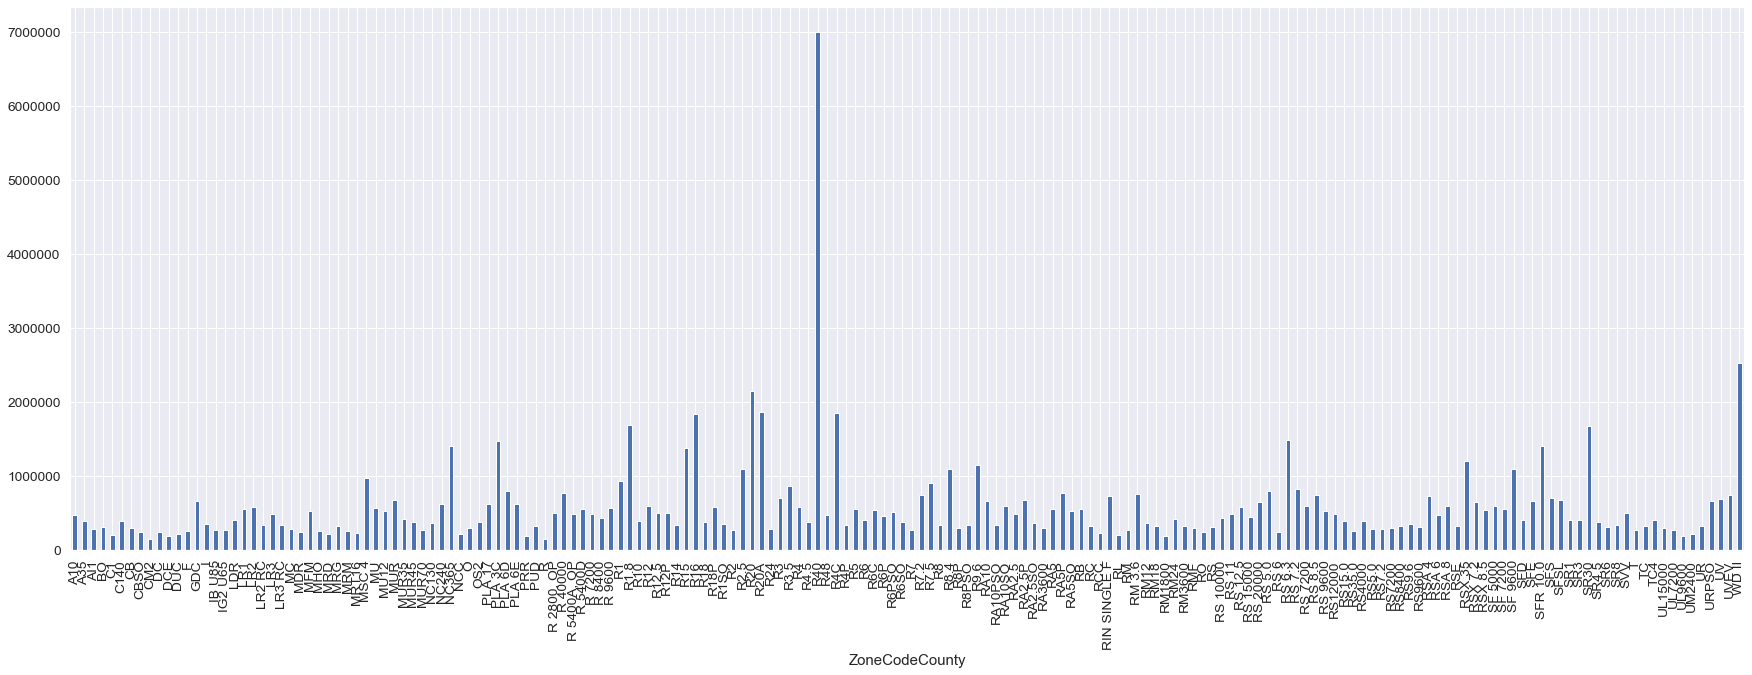

In [1843]:
# check relation between home price and zone
fig= plt.figure(figsize=(30,10))
data.groupby('ZoneCodeCounty')['SaleDollarCnt'].median().plot.bar()
plt.show()

From the visualization,it can be observed that the median home prices vary by zones. And the median home prices in zone R40 is significantly higher than other zones.

### Temporal features

In [1845]:
# Find temporal features
year_features = [feature for feature in data.columns if 'Year' in feature]

## number of temporal features
print('Number of temporal features are:', len(year_features))

# check temporal features
data[year_features].head()

Number of temporal features are: 2


,BuiltYear,BGMedYearBuilt
0,1965.000,1975.000
1,1953.000,1969.000
2,1955.000,1946.000
3,1962.000,1977.000
4,1948.000,1972.000


There are only 2 temporal features.

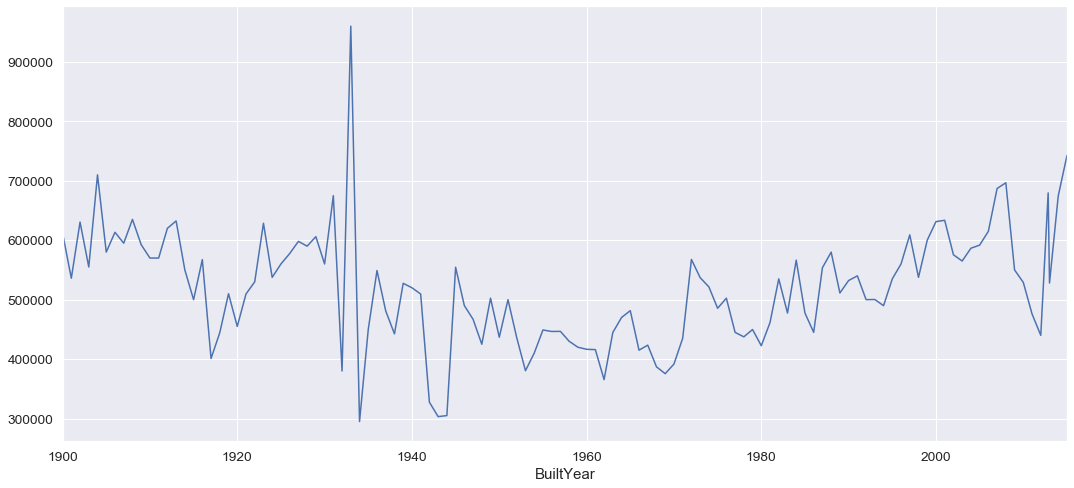

In [1846]:
# Checking relation of built year with home prices
fig= plt.figure(figsize=(18,8))
data.groupby('BuiltYear')['SaleDollarCnt'].median().plot()

From the visualization it can be observed that home prices vary with builtyear but I cannot see any visible pattern between them.

### Numerical features

In [1847]:
# Find numerical features
numerical_features = [feature for feature in data.columns if data[feature].dtypes != 'O' and feature not in year_features]

# number of numerical features
print('Number of numerical features are:', len(numerical_features))

# check numerical features
data[numerical_features].head()

Number of numerical features are: 18


,SaleDollarCnt,BedroomCnt,BathroomCnt,FinishedSquareFeet,GarageSquareFeet,LotSizeSquareFeet,StoryCnt,ViewType,Latitude,Longitude,BGMedHomeValue,BGMedRent,BGPctOwn,BGPctVacant,BGMedIncome,BGPctKids,BGMedAge,TransMonth
0,285000.000,4.000,2.000,1900.000,480.000,7482,1.000,nan,47321389,-122213716,107800.000,844.000,0.668,0.078,42854,0.192,48.600,5
1,309950.000,3.000,2.000,2170.000,320.000,14208,1.000,79.000,47482082,-122244269,181500.000,925.000,0.575,0.019,54013,0.372,42.600,8
2,476000.000,4.000,1.000,2150.000,590.000,6500,1.000,nan,47561383,-122308083,344300.000,733.000,0.633,0.000,56782,0.321,40.700,8
3,324950.000,4.000,2.250,2560.000,nan,15767,1.000,79.000,47387929,-122279389,284200.000,900.000,0.546,0.057,44200,0.336,40.000,7
4,325000.000,4.000,1.750,1720.000,nan,8620,2.000,78.000,47477068,-122263852,290100.000,802.000,0.427,0.055,65282,0.163,44.400,6


There are 18 numerical features in the training data. It's important to check which features are discrete and which are continuous.

In [1848]:
# Find discrete numerical features
discrete_features = [feature for feature in numerical_features if len(data[feature].unique()) < 35 and feature not in year_features]

# number of discrete numerical features
print("Number of discrete variables are", len(discrete_features))

# show discrete numerical features
data[discrete_features].head()

Number of discrete variables are 5


,BedroomCnt,BathroomCnt,StoryCnt,ViewType,TransMonth
0,4.000,2.000,1.000,nan,5
1,3.000,2.000,1.000,79.000,8
2,4.000,1.000,1.000,nan,8
3,4.000,2.250,1.000,79.000,7
4,4.000,1.750,2.000,78.000,6


There are 5 discrete numerical features. Lets check their relation with home prices by visualization.

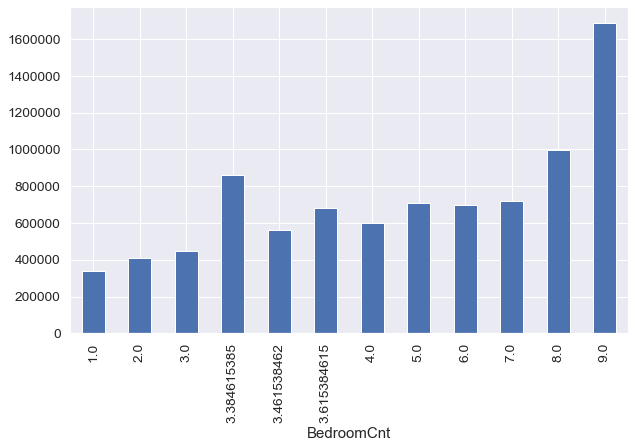

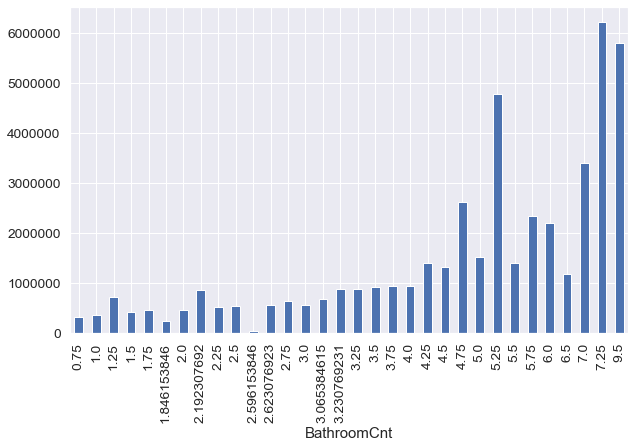

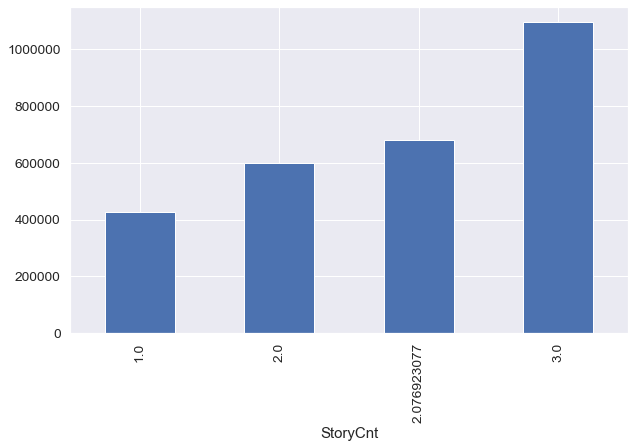

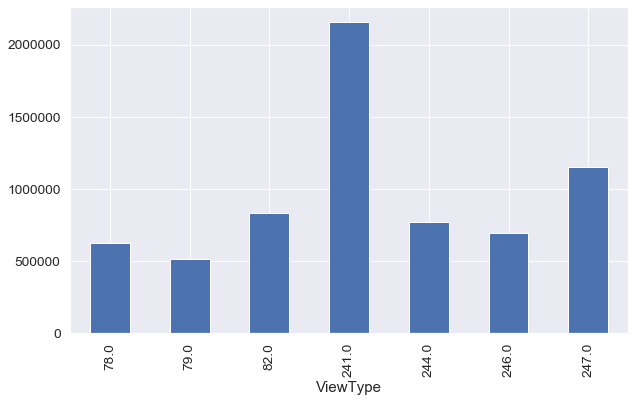

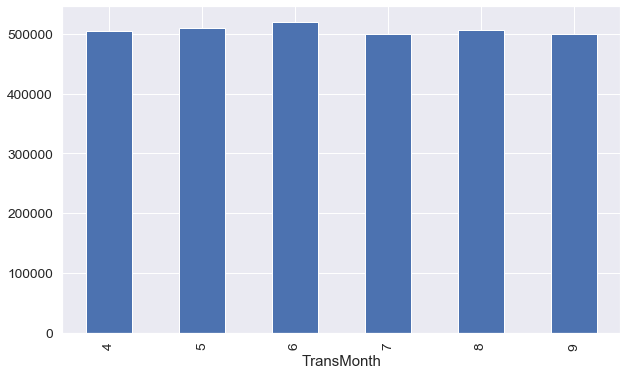

In [1849]:
# check relation of discrete numerical features with home prices
for feature in discrete_features:
    fig= plt.figure(figsize=(10,6))
    dataset = data.copy()
    dataset.groupby(feature)['SaleDollarCnt'].median().plot.bar()
    plt.show()  

From the above visualizations, some significant observations are -
1. Home prices varies with number of bedrooms and home prices with bedroom 8 and 9 are higher than others.
2. There's approximately monotonic increase in home prices with number of bathroom
3. Home prices increase monotonically as number of stories increases
4. View type of '241' has significantly higher home prices than others


In [1850]:
# Find continuous numerical features
continuous_features = [feature for feature in numerical_features if len(data[feature].unique()) > 35 and feature not in year_features]

# number of continuous numerical features
print("Number of continuous variables are", len(continuous_features))

# show continuous numerical features
data[continuous_features].head()

Number of continuous variables are 13


,SaleDollarCnt,FinishedSquareFeet,GarageSquareFeet,LotSizeSquareFeet,Latitude,Longitude,BGMedHomeValue,BGMedRent,BGPctOwn,BGPctVacant,BGMedIncome,BGPctKids,BGMedAge
0,285000.000,1900.000,480.000,7482,47321389,-122213716,107800.000,844.000,0.668,0.078,42854,0.192,48.600
1,309950.000,2170.000,320.000,14208,47482082,-122244269,181500.000,925.000,0.575,0.019,54013,0.372,42.600
2,476000.000,2150.000,590.000,6500,47561383,-122308083,344300.000,733.000,0.633,0.000,56782,0.321,40.700
3,324950.000,2560.000,nan,15767,47387929,-122279389,284200.000,900.000,0.546,0.057,44200,0.336,40.000
4,325000.000,1720.000,nan,8620,47477068,-122263852,290100.000,802.000,0.427,0.055,65282,0.163,44.400


There are 13 continuous numerical features. Lets check their relation with home prices by visualization.

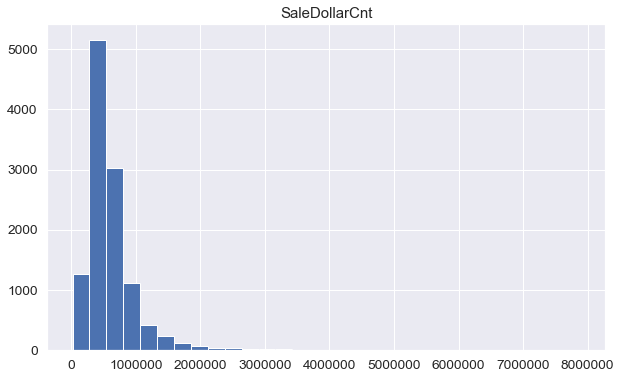

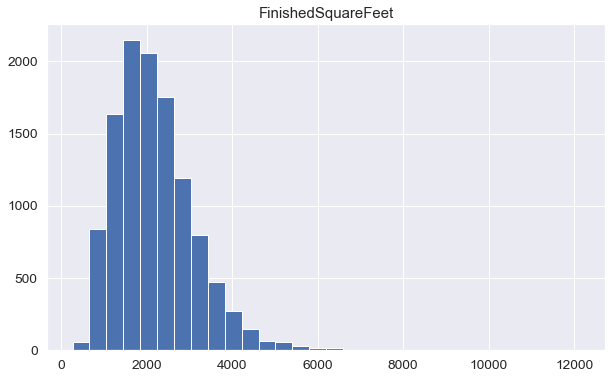

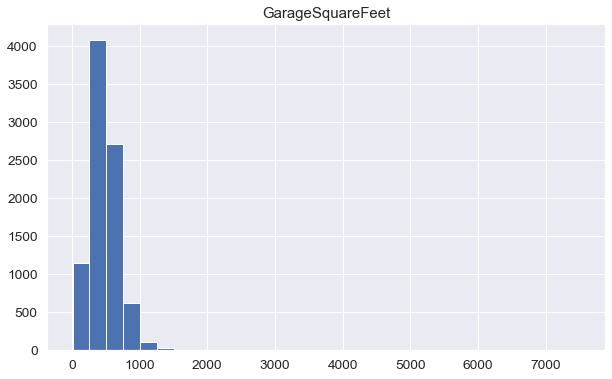

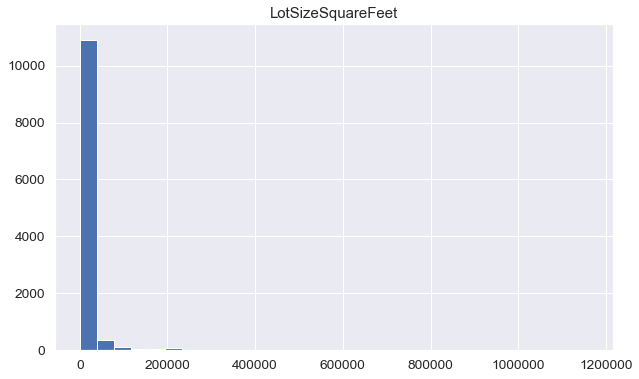

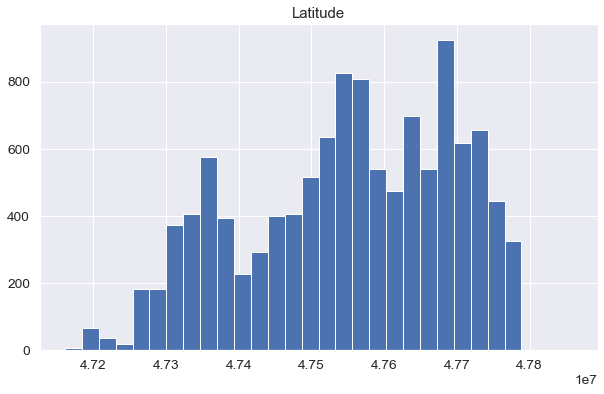

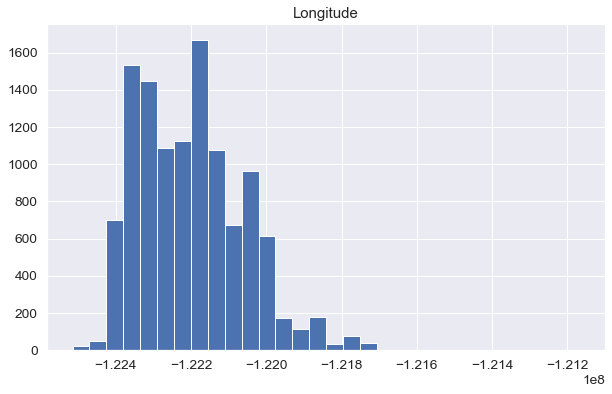

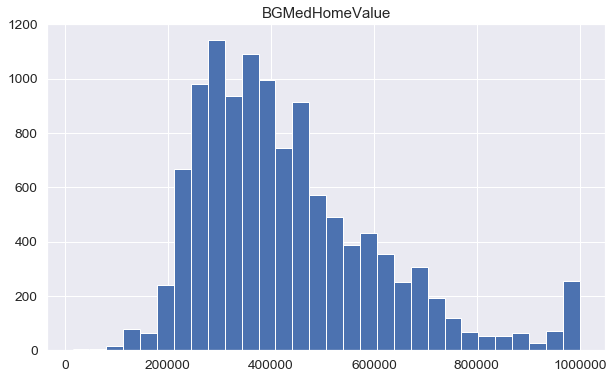

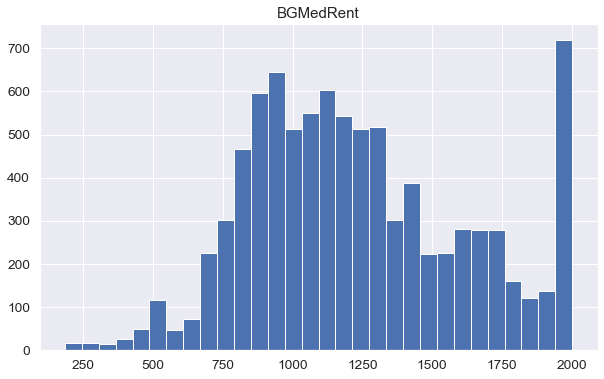

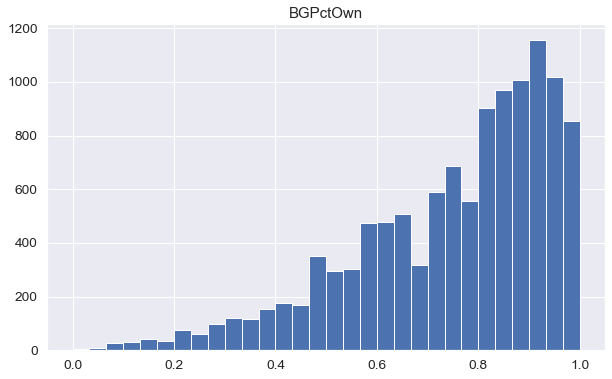

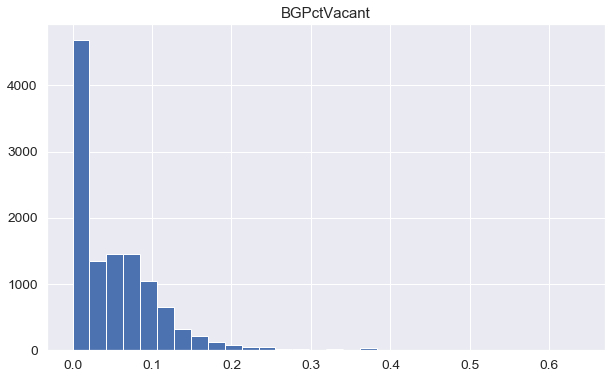

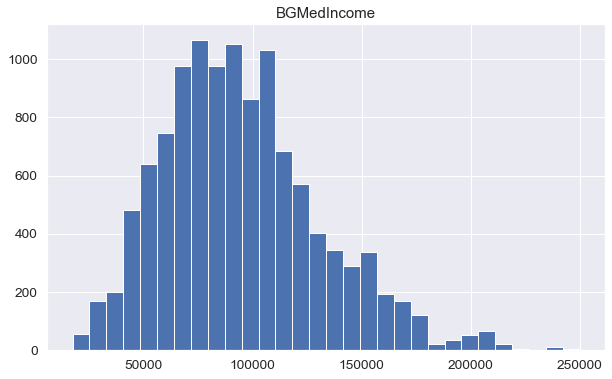

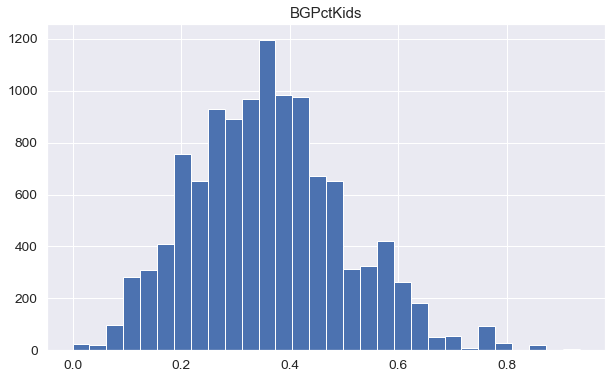

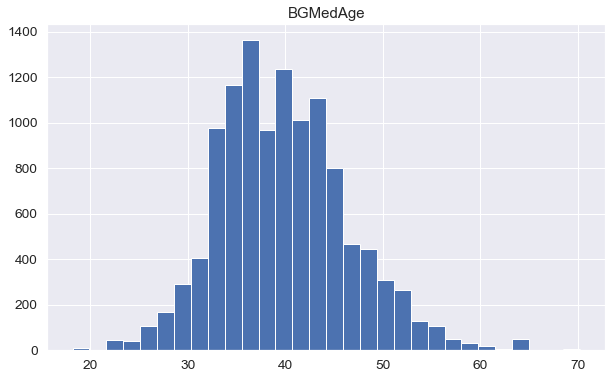

In [1851]:
# check relation of continuous numerical features with home prices
for feature in continuous_features:
    fig= plt.figure(figsize=(10,6))
    dataset = data.copy()
    dataset[feature].hist(bins=30)
    plt.title(feature)
    plt.show()

From the above visualizations, some significant observations are -
1. Variables like BGPctKids, BGMedAge, BGMedIncome, BGMedRent, FinishedSquareFeet have almost normal distributions which a few outliers.
2. LotSizeSquareFeet doesn't have a normal distribution
3. Home prices(SaleDollarCnt) have a normal distribution with graph skewed to the right
4. Distribution of BGPctVacant and BGPctOwn is highly skewed


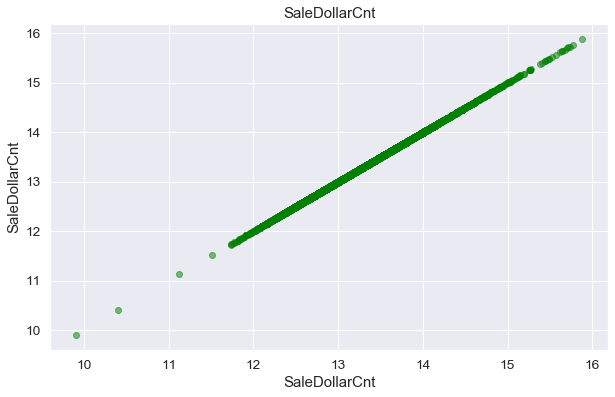

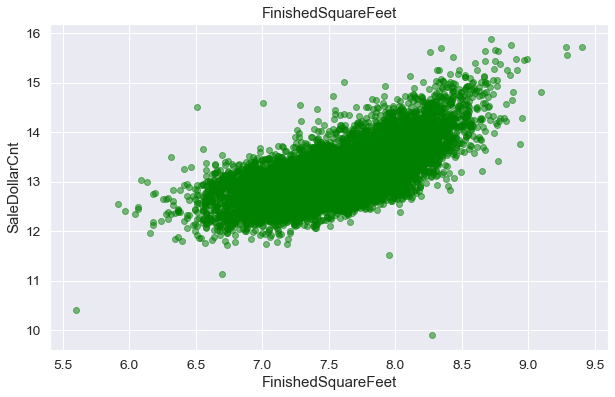

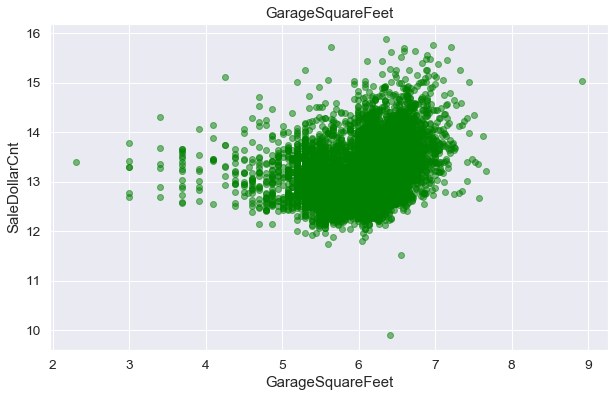

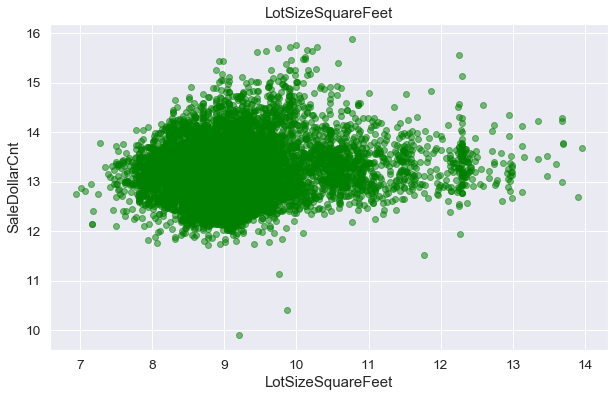

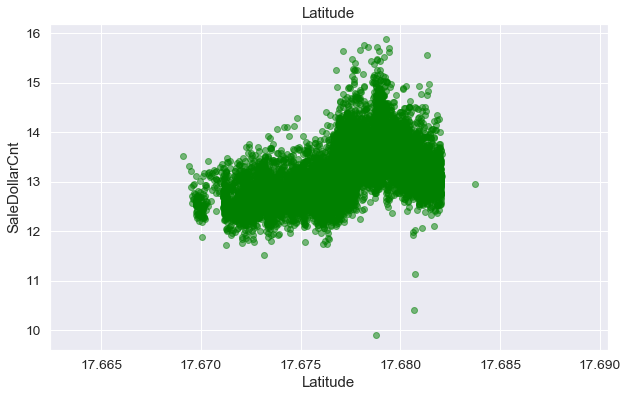

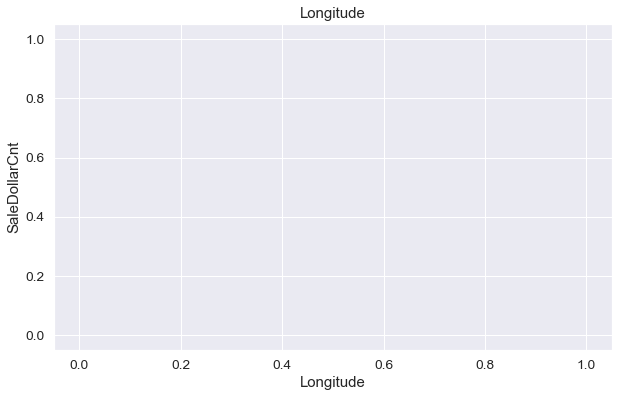

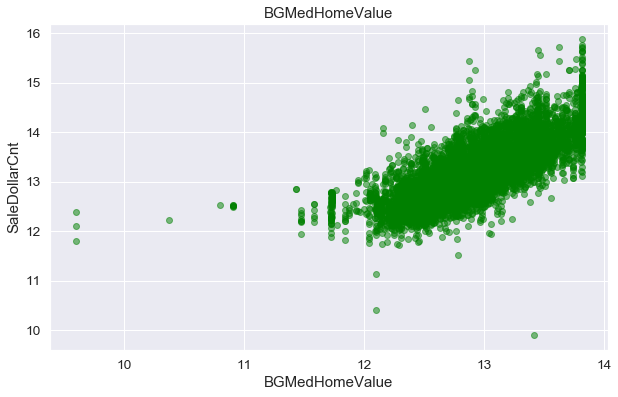

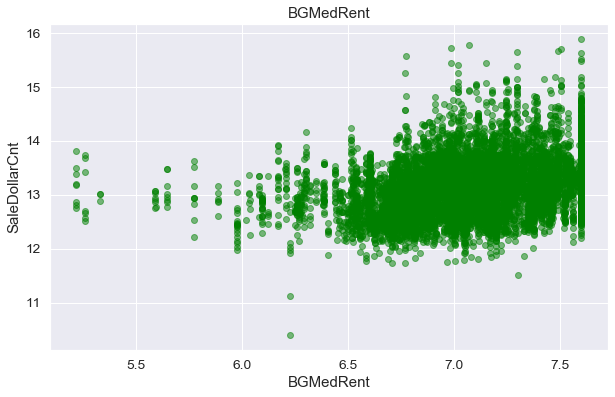

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

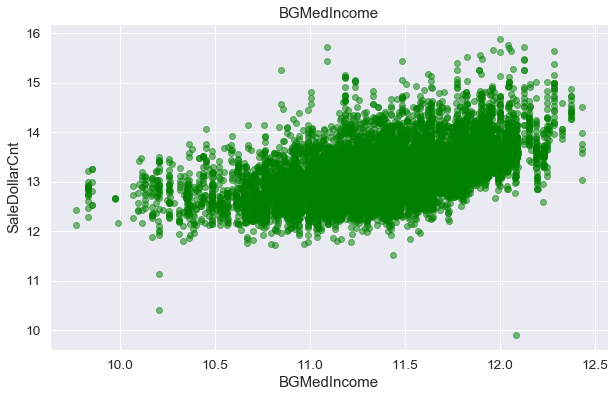

<Figure size 720x432 with 0 Axes>

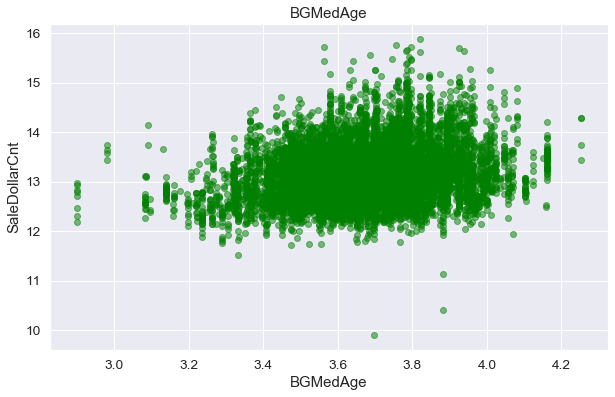

In [1852]:
### Converting continuous numerical features to log normal form to avoid outliers and checking their relationship with Home prices.
for feature in continuous_features:
    fig= plt.figure(figsize=(10,6))
    dataset = data.copy()
    if 0 in dataset[feature].unique():
        pass
    else:
        dataset[feature]=np.log(dataset[feature])
        dataset['SaleDollarCnt']=np.log(data['SaleDollarCnt'])
        plt.scatter(dataset[feature],dataset['SaleDollarCnt'], c='green', alpha=0.5)
        plt.xlabel(feature)
        plt.ylabel('SaleDollarCnt')
        plt.title(feature)
        plt.show()

From the above visualizations, some significant observations are -
1. There's a almost linear relationship between home prices and finished square feet and median income. 
2. There's a almost linear relationship between home prices and median home value.
3. There might be some relationship between home prices and median age.

### Outliers

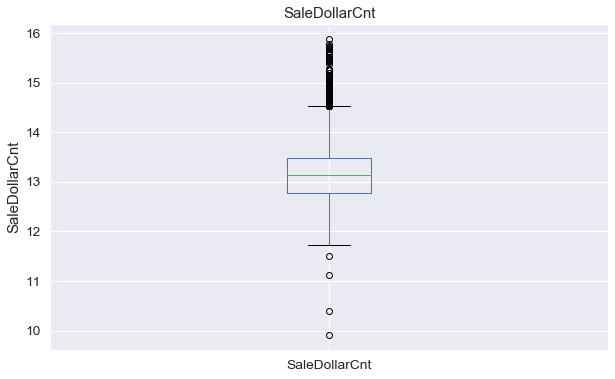

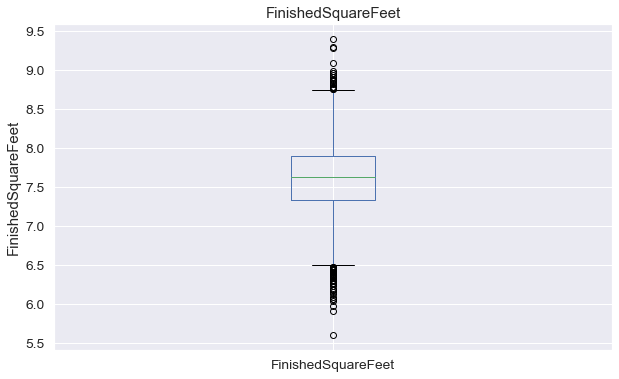

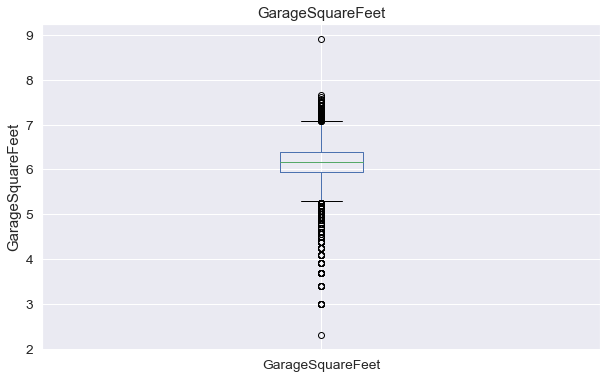

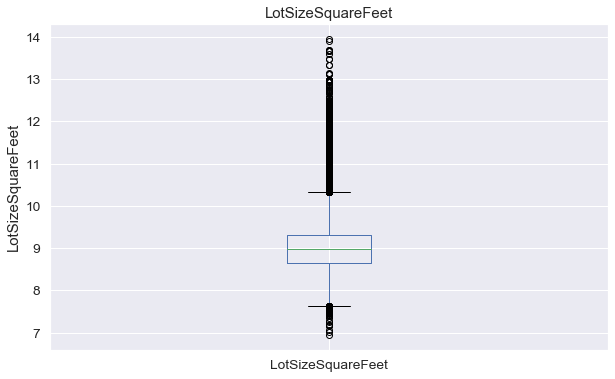

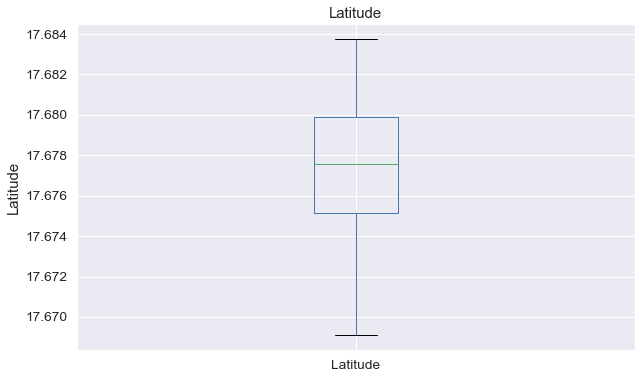

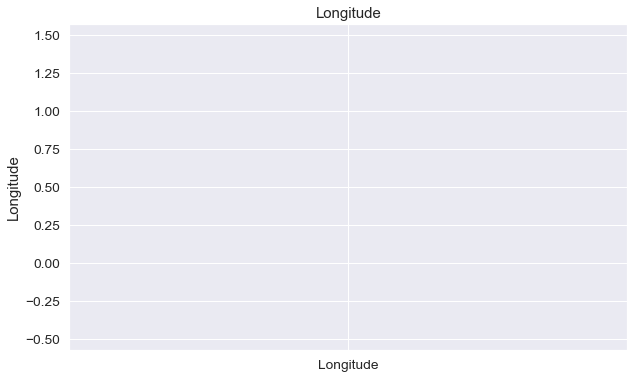

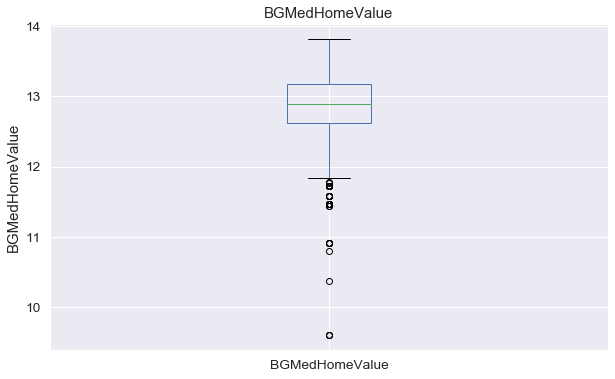

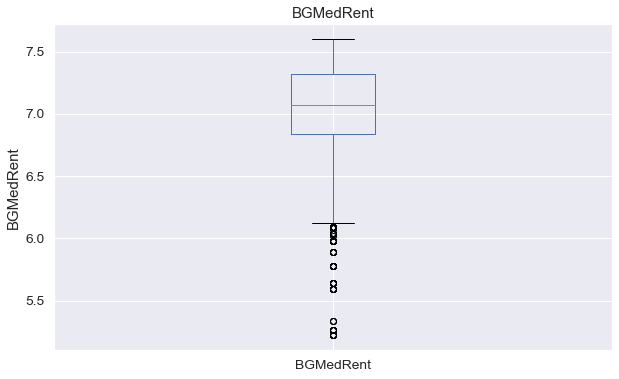

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

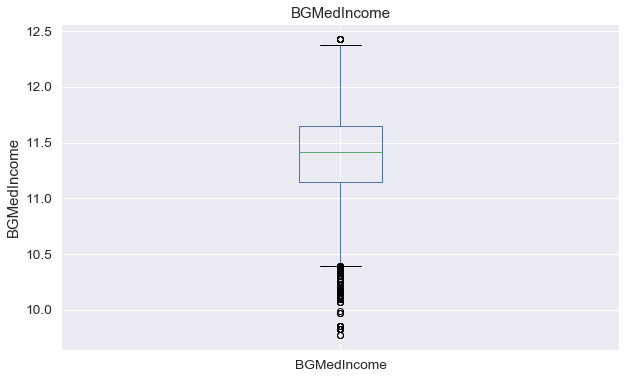

<Figure size 720x432 with 0 Axes>

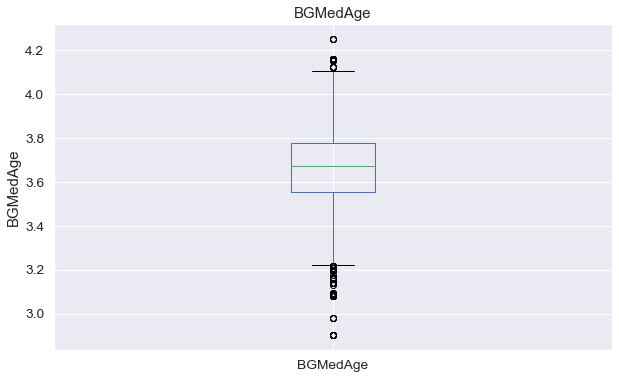

In [1853]:
# creating box plots to check outliers in continuous numerical features
for feature in continuous_features:
    fig= plt.figure(figsize=(10,6))
    dataset  = data.copy()
    if 0 in dataset[feature].unique():
        pass
    else:
        dataset[feature]=np.log(dataset[feature])
        dataset.boxplot(column=feature)
        plt.ylabel(feature)
        plt.title(feature)
        plt.show()

From the above visualizations, I observed that there are outliers present in all the continuous numerical features except in latitude.

# Feature Engineering

### Handlig missing values

In [1854]:
# Recheck missing features we found in exploratory data analysis
missing_features

,Total Missing Values,Percentage Missing Values
BGMedHomeValue,6,0.052
BGMedRent,2631,22.704
BGMedYearBuilt,247,2.131
GarageSquareFeet,2841,24.517
ViewType,8956,77.287


In [1855]:
# Imputing missing variables
data['BGMedYearBuilt'] = data['BGMedYearBuilt'].fillna(data['BGMedYearBuilt'].mode()[0])

data['ViewType'] = data['ViewType'].fillna(0)

data['BGMedRent'] = data['BGMedRent'].fillna(data['BGMedRent']).median()
    
data['BGMedHomeValue'] = data['BGMedHomeValue'].fillna(data['BGMedHomeValue']).median()
                                                       
data['GarageSquareFeet'] = data['GarageSquareFeet'].fillna(data['GarageSquareFeet']).median()

Handling missing values-
1. I have replaced missing values in 'BGMedRent', 'BGMedHomeValue', 'GarageSquareFeet' with their respective medains.
2. I have represented no view with 0
3. I have replaced missing 'BGMedYearBuilt' with the most frequent BGMedYearBuilt

If information about blocks would have been provided I would have imputed my missing values(BGMedRent, BGMedHomeValue,GarageSquareFeet) by grouping them with blocks.

In [1856]:
# verify number of missing vaules after imputing missing values
data.isnull().sum()

SaleDollarCnt         0
ZoneCodeCounty        0
BedroomCnt            0
BathroomCnt           0
FinishedSquareFeet    0
GarageSquareFeet      0
LotSizeSquareFeet     0
StoryCnt              0
BuiltYear             0
ViewType              0
Latitude              0
Longitude             0
BGMedHomeValue        0
BGMedRent             0
BGMedYearBuilt        0
BGPctOwn              0
BGPctVacant           0
BGMedIncome           0
BGPctKids             0
BGMedAge              0
TransMonth            0
dtype: int64

There are 0 missing values in the training data.

In [1857]:
# Converting the continuous numerical features to log normal form to remove outliers
Log_features = ['FinishedSquareFeet', 'GarageSquareFeet', 'LotSizeSquareFeet', 'BGMedHomeValue', 'BGMedRent', 'BGMedIncome', 'BGMedAge','SaleDollarCnt']

for feature in Log_features:
    data[feature]=np.log(data[feature])

# check data after log normal transformation
data.head()

,SaleDollarCnt,ZoneCodeCounty,BedroomCnt,BathroomCnt,FinishedSquareFeet,GarageSquareFeet,LotSizeSquareFeet,StoryCnt,BuiltYear,ViewType,Latitude,Longitude,BGMedHomeValue,BGMedRent,BGMedYearBuilt,BGPctOwn,BGPctVacant,BGMedIncome,BGPctKids,BGMedAge,TransMonth
0,12.560,R7,4.000,2.000,7.550,6.165,8.920,1.000,1965.000,0.000,47321389,-122213716,12.891,7.067,1975.000,0.668,0.078,10.666,0.192,3.884,5
1,12.644,R8P,3.000,2.000,7.682,6.165,9.562,1.000,1953.000,79.000,47482082,-122244269,12.891,7.067,1969.000,0.575,0.019,10.897,0.372,3.752,8
2,13.073,SF 7200,4.000,1.000,7.673,6.165,8.780,1.000,1955.000,0.000,47561383,-122308083,12.891,7.067,1946.000,0.633,0.000,10.947,0.321,3.706,8
3,12.691,R1,4.000,2.250,7.848,6.165,9.666,1.000,1962.000,79.000,47387929,-122279389,12.891,7.067,1977.000,0.546,0.057,10.696,0.336,3.689,7
4,12.692,LDR,4.000,1.750,7.450,6.165,9.062,2.000,1948.000,78.000,47477068,-122263852,12.891,7.067,1972.000,0.427,0.055,11.086,0.163,3.793,6


The continuous numerical features have been successfully transformed to log normal form. Thus, we have handeled the outliers in this step.

In [1858]:
## Handling categorical feature
# find percentage of transaction in each zone
perct = data.groupby('ZoneCodeCounty')['SaleDollarCnt'].count()/len(data)

perct_df= perct[perct>0.01].index

# replace zones occuured less than 1% with 'Uncommon' label
data['ZoneCodeCounty'] = np.where(data['ZoneCodeCounty'].isin(perct_df), data['ZoneCodeCounty'],'Uncommon')

In the above code, I am checking those zones where transaction occured less than 1% of the time. I am replacing them with a new label called 'Uncommon' and retaining others as it is.
This will improve my price prediction.

In [1859]:
# check cardinality of zone codes
print("Cardinality of zones are:", data[categorical_features].nunique())

Cardinality of zones are: ZoneCodeCounty    19
dtype: int64


The cardinality of zone codes drastically reduced from 178 to 19. This can prove instrumental in predicting the home prices.

In [1860]:
## Label encoding of zone codes
labels = data.groupby('ZoneCodeCounty')['SaleDollarCnt'].mean().sort_values().index

labels = {k:i for i,k in enumerate(labels,0)}
data['ZoneCodeCounty'] = data['ZoneCodeCounty'].map(labels)

# check data after label encoding
data.head(10)

,SaleDollarCnt,ZoneCodeCounty,BedroomCnt,BathroomCnt,FinishedSquareFeet,GarageSquareFeet,LotSizeSquareFeet,StoryCnt,BuiltYear,ViewType,Latitude,Longitude,BGMedHomeValue,BGMedRent,BGMedYearBuilt,BGPctOwn,BGPctVacant,BGMedIncome,BGPctKids,BGMedAge,TransMonth
0,12.560,0,4.000,2.000,7.550,6.165,8.920,1.000,1965.000,0.000,47321389,-122213716,12.891,7.067,1975.000,0.668,0.078,10.666,0.192,3.884,5
1,12.644,9,3.000,2.000,7.682,6.165,9.562,1.000,1953.000,79.000,47482082,-122244269,12.891,7.067,1969.000,0.575,0.019,10.897,0.372,3.752,8
2,13.073,14,4.000,1.000,7.673,6.165,8.780,1.000,1955.000,0.000,47561383,-122308083,12.891,7.067,1946.000,0.633,0.000,10.947,0.321,3.706,8
3,12.691,17,4.000,2.250,7.848,6.165,9.666,1.000,1962.000,79.000,47387929,-122279389,12.891,7.067,1977.000,0.546,0.057,10.696,0.336,3.689,7
4,12.692,9,4.000,1.750,7.450,6.165,9.062,2.000,1948.000,78.000,47477068,-122263852,12.891,7.067,1972.000,0.427,0.055,11.086,0.163,3.793,6
5,12.367,9,3.000,1.000,7.265,6.165,8.936,2.000,1930.000,0.000,47478287,-122264698,12.891,7.067,1972.000,0.427,0.055,11.086,0.163,3.793,4
6,13.390,15,4.000,1.500,7.654,6.165,8.854,2.000,1915.000,0.000,47578139,-122294489,12.891,7.067,1955.000,0.576,0.000,11.111,0.271,3.811,7
7,12.821,9,3.000,2.000,7.467,6.165,10.448,2.000,1961.000,78.000,47493229,-122261042,12.891,7.067,1972.000,0.323,0.000,10.791,0.124,3.691,9
8,12.722,15,2.000,1.000,6.672,6.165,8.564,1.000,1925.000,0.000,47530271,-122288466,12.891,7.067,1957.000,0.832,0.071,10.755,0.364,3.689,9
9,13.346,15,3.000,2.250,7.427,6.165,8.259,2.000,1988.000,0.000,47680263,-122301434,12.891,7.067,1955.000,0.705,0.000,11.452,0.254,3.535,7


In the above step, I have successfully performed label endcoing on 'ZoneCodeCounty' column to convert labels in zone code to numerical values.

### Feature scaling

In [1861]:
# Scaling features uisng MinMax scaler to avoid any glitches because of different units of measurement
scale_features=[feature for feature in data.columns if feature not in ['SaleDollarCnt']]

# using minmax scaler
scaler=MinMaxScaler()
scaler.fit(data[scale_features])

dataset = pd.concat([data['SaleDollarCnt'].reset_index(drop=True), pd.DataFrame(scaler.transform(data[scale_features]), columns = scale_features)], axis=1)

# check data after feature scaling
dataset.head(10)

,SaleDollarCnt,ZoneCodeCounty,BedroomCnt,BathroomCnt,FinishedSquareFeet,GarageSquareFeet,LotSizeSquareFeet,StoryCnt,BuiltYear,ViewType,Latitude,Longitude,BGMedHomeValue,BGMedRent,BGMedYearBuilt,BGPctOwn,BGPctVacant,BGMedIncome,BGPctKids,BGMedAge,TransMonth
0,12.560,0.000,0.375,0.143,0.513,0.000,0.282,0.000,0.565,0.000,0.230,0.223,0.000,0.000,0.545,0.668,0.122,0.337,0.206,0.728,0.200
1,12.644,0.500,0.250,0.143,0.548,0.000,0.373,0.000,0.461,0.320,0.460,0.201,0.000,0.000,0.455,0.575,0.030,0.424,0.398,0.630,0.800
2,13.073,0.778,0.375,0.029,0.545,0.000,0.262,0.000,0.478,0.000,0.574,0.153,0.000,0.000,0.106,0.633,0.000,0.443,0.343,0.596,0.800
3,12.691,0.944,0.375,0.171,0.591,0.000,0.388,0.000,0.539,0.320,0.325,0.175,0.000,0.000,0.576,0.546,0.090,0.348,0.360,0.583,0.600
4,12.692,0.500,0.375,0.114,0.487,0.000,0.302,0.500,0.417,0.316,0.453,0.186,0.000,0.000,0.500,0.427,0.086,0.495,0.175,0.661,0.400
5,12.367,0.500,0.250,0.029,0.438,0.000,0.284,0.500,0.261,0.000,0.455,0.186,0.000,0.000,0.500,0.427,0.086,0.495,0.175,0.661,0.000
6,13.390,0.833,0.375,0.086,0.540,0.000,0.272,0.500,0.130,0.000,0.598,0.164,0.000,0.000,0.242,0.576,0.000,0.504,0.290,0.674,0.600
7,12.821,0.500,0.250,0.143,0.491,0.000,0.499,0.500,0.530,0.316,0.476,0.188,0.000,0.000,0.500,0.323,0.000,0.384,0.133,0.585,1.000
8,12.722,0.833,0.125,0.029,0.282,0.000,0.231,0.000,0.217,0.000,0.529,0.168,0.000,0.000,0.273,0.832,0.112,0.371,0.389,0.583,1.000
9,13.346,0.833,0.250,0.171,0.480,0.000,0.188,0.500,0.765,0.000,0.744,0.158,0.000,0.000,0.242,0.705,0.000,0.633,0.272,0.469,0.600


The minmax scaling has converted the values in each feature between 0 and 1 except our traget variable i.e 'SaleDollarCnt'.

In [1862]:
# Separating target variable and storing in y_train
y_train = pd.DataFrame(dataset['SaleDollarCnt'])

# check target variable
y_train.head()

,SaleDollarCnt
0,12.560
1,12.644
2,13.073
3,12.691
4,12.692


In [1863]:
# Removing target variable from other features
X_train = dataset.drop('SaleDollarCnt', axis=1)
X_train.head()

,ZoneCodeCounty,BedroomCnt,BathroomCnt,FinishedSquareFeet,GarageSquareFeet,LotSizeSquareFeet,StoryCnt,BuiltYear,ViewType,Latitude,Longitude,BGMedHomeValue,BGMedRent,BGMedYearBuilt,BGPctOwn,BGPctVacant,BGMedIncome,BGPctKids,BGMedAge,TransMonth
0,0.000,0.375,0.143,0.513,0.000,0.282,0.000,0.565,0.000,0.230,0.223,0.000,0.000,0.545,0.668,0.122,0.337,0.206,0.728,0.200
1,0.500,0.250,0.143,0.548,0.000,0.373,0.000,0.461,0.320,0.460,0.201,0.000,0.000,0.455,0.575,0.030,0.424,0.398,0.630,0.800
2,0.778,0.375,0.029,0.545,0.000,0.262,0.000,0.478,0.000,0.574,0.153,0.000,0.000,0.106,0.633,0.000,0.443,0.343,0.596,0.800
3,0.944,0.375,0.171,0.591,0.000,0.388,0.000,0.539,0.320,0.325,0.175,0.000,0.000,0.576,0.546,0.090,0.348,0.360,0.583,0.600
4,0.500,0.375,0.114,0.487,0.000,0.302,0.500,0.417,0.316,0.453,0.186,0.000,0.000,0.500,0.427,0.086,0.495,0.175,0.661,0.400



### My training data is ready to be fed into the model. But before model building, lets quickly perform data analysis and feature engineering in test data.

In [1864]:
# Load test data
test =  pd.read_csv("Data Science ZExercise_TEST_CONFIDENTIAL2.csv")

# chekc first few observations
test.head()

,PropertyID,SaleDollarCnt,TransDate,censusblockgroup,ZoneCodeCounty,Usecode,BedroomCnt,BathroomCnt,FinishedSquareFeet,GarageSquareFeet,LotSizeSquareFeet,StoryCnt,BuiltYear,ViewType,Latitude,Longitude,BGMedHomeValue,BGMedRent,BGMedYearBuilt,BGPctOwn,BGPctVacant,BGMedIncome,BGPctKids,BGMedAge
0,48735321,nan,10/31/2015,530000000000.000,SF 9600,9,5.000,4.000,5540,nan,25338,1.000,1940.000,78.000,47725642,-122283771,527700.000,1750.000,1956.000,0.913,0.106,113450,0.252,49.600
1,48735471,nan,11/6/2015,530000000000.000,SF 9600,9,5.000,3.000,2470,510.000,26006,1.000,1966.000,78.000,47726993,-122281969,527700.000,1750.000,1956.000,0.913,0.106,113450,0.252,49.600
2,49128764,nan,10/17/2015,530000000000.000,SF 7200,9,4.000,2.000,1680,nan,8743,2.000,1928.000,nan,47731749,-122289304,527700.000,1750.000,1956.000,0.913,0.106,113450,0.252,49.600
3,48897535,nan,11/19/2015,530000000000.000,SF 7200,9,2.000,1.000,990,260.000,12219,1.000,1940.000,nan,47728810,-122289224,527700.000,1750.000,1956.000,0.913,0.106,113450,0.252,49.600
4,49083957,nan,12/15/2015,530000000000.000,SF 9600,9,4.000,3.000,2960,550.000,23568,1.000,1951.000,82.000,47731170,-122282684,527700.000,1750.000,1956.000,0.913,0.106,113450,0.252,49.600


In [1865]:
test.shape

(4402, 24)

There are 4402 rows and 24 columns in test data

In [1866]:
test.dtypes.value_counts()

float64    15
int64       7
object      2
dtype: int64

In [1867]:
# Check for columns having a unique value i.e non-variance in the column
for feature in test.columns:
    if (len(test[feature].unique()) == 1):
        print(feature)

SaleDollarCnt
censusblockgroup
Usecode


In [1868]:
# check 'PropertyID', 'censusblockgroup' and 'Usecode' for test data
print('length of property id:',test['PropertyID'].nunique())
print('length of property id:', len(test['censusblockgroup']))
print('values in censusblockgroup:',test['censusblockgroup'].unique())
print('length of property id:', len(test['Usecode']))
print('values in Usecode:',test['Usecode'].unique())

length of property id: 4402
length of property id: 4402
values in censusblockgroup: [5.3e+11]
length of property id: 4402
values in Usecode: [9]


I observed that columns like 'PropertyID', 'censusblockgroup' and 'Usecode' have no missing values. 'PropertyID' is unique to each observation.'censusblockgroup' and 'Usecode' have same value throughout the training data. This observation is similar to training data.Hence, dropping them in test data as well.
Additionally, I am dropping the target variable i.e SaledollarCnt as it's value has to be predicted.

In [1869]:
# Droppping above mentioned features
test.drop(columns=['PropertyID', 'censusblockgroup', 'Usecode', 'SaleDollarCnt'], axis = 1, inplace = True)

In [1870]:
# check shape of test data
test.shape

(4402, 20)

I have successfuly dropped the unnecessary columns

In [1871]:
# check missing features
missing_features = missing_values(test)
missing_features

,Total Missing Values,Percentage Missing Values
BGMedHomeValue,7,0.159
BGMedRent,963,21.876
BGMedYearBuilt,62,1.409
GarageSquareFeet,1138,25.852
ViewType,3404,77.329


In [1872]:
# Convert date to date type
test['TransDate'] = pd.to_datetime(test['TransDate'])

In [1873]:
test['TransMonth'] = test['TransDate'].dt.month.astype(np.int64)

In [1874]:
test.drop(['TransDate'], axis=1, inplace=True)

I have performed same operation on 'TransDate' column on test data as I performed in tarining data

In [1875]:
# Impute missing values in test data 
test['BGMedYearBuilt'] = test['BGMedYearBuilt'].fillna(test['BGMedYearBuilt'].mode()[0])

test['ViewType'] = test['ViewType'].fillna(0)

test['BGMedRent'] = test['BGMedRent'].fillna(test['BGMedRent']).median()
    
test['BGMedHomeValue'] = test['BGMedHomeValue'].fillna(test['BGMedHomeValue']).median()
                                                       
test['GarageSquareFeet'] = test['GarageSquareFeet'].fillna(test['GarageSquareFeet']).median()

Handling missing values-

1. I have replaced missing values in 'BGMedRent', 'BGMedHomeValue', 'GarageSquareFeet' with their respective medains.
2. I have represented no view with 0
3. I have replaced missing 'BGMedYearBuilt' with the most frequent BGMedYearBuilt

If information about blocks would have been provided I would have imputed my missing values(BGMedRent, BGMedHomeValue,GarageSquareFeet) by grouping them with blocks.

In [1876]:
# verify if any null values are still present
test.isnull().any()

ZoneCodeCounty        False
BedroomCnt            False
BathroomCnt           False
FinishedSquareFeet    False
GarageSquareFeet      False
LotSizeSquareFeet     False
StoryCnt              False
BuiltYear             False
ViewType              False
Latitude              False
Longitude             False
BGMedHomeValue        False
BGMedRent             False
BGMedYearBuilt        False
BGPctOwn              False
BGPctVacant           False
BGMedIncome           False
BGPctKids             False
BGMedAge              False
TransMonth            False
dtype: bool

There are no null values in the test data

In [1877]:
# Converting continuous numerical features in log normal form to remove outliers, as I did for training data 
Log_test_features = ['FinishedSquareFeet', 'GarageSquareFeet', 'LotSizeSquareFeet', 'BGMedHomeValue', 'BGMedRent', 'BGMedIncome', 'BGMedAge']

for feature in Log_test_features:
    test[feature]=np.log(test[feature])
test.head()

,ZoneCodeCounty,BedroomCnt,BathroomCnt,FinishedSquareFeet,GarageSquareFeet,LotSizeSquareFeet,StoryCnt,BuiltYear,ViewType,Latitude,Longitude,BGMedHomeValue,BGMedRent,BGMedYearBuilt,BGPctOwn,BGPctVacant,BGMedIncome,BGPctKids,BGMedAge,TransMonth
0,SF 9600,5.000,4.000,8.620,6.174,10.140,1.000,1940.000,78.000,47725642,-122283771,12.872,7.060,1956.000,0.913,0.106,11.639,0.252,3.904,10
1,SF 9600,5.000,3.000,7.812,6.174,10.166,1.000,1966.000,78.000,47726993,-122281969,12.872,7.060,1956.000,0.913,0.106,11.639,0.252,3.904,11
2,SF 7200,4.000,2.000,7.427,6.174,9.076,2.000,1928.000,0.000,47731749,-122289304,12.872,7.060,1956.000,0.913,0.106,11.639,0.252,3.904,10
3,SF 7200,2.000,1.000,6.898,6.174,9.411,1.000,1940.000,0.000,47728810,-122289224,12.872,7.060,1956.000,0.913,0.106,11.639,0.252,3.904,11
4,SF 9600,4.000,3.000,7.993,6.174,10.068,1.000,1951.000,82.000,47731170,-122282684,12.872,7.060,1956.000,0.913,0.106,11.639,0.252,3.904,12


### Changing categorical variable to numerical form by label encoding

In [1878]:
test['ZoneCodeCounty'].nunique()

143

As compared to training data where 178 uniques zone codes were present, there are 143 zone codes in test data

In [1879]:
# check if test and train data have differnt zone codes
for code in test['ZoneCodeCounty'].unique():
    if code not in data['ZoneCodeCounty'].unique():
        print("There are differnt zone codes in test and train data.")
        break

There are differnt zone codes in test and train data.


In [1880]:
## Label encoding zone codes
test['ZoneCodeCounty'] = test['ZoneCodeCounty'].map(labels)

In the above code, I am encoding zone codes in test data using the similar mapping from training data.
But there are some different zone code in test data which are not present in training data. 
Since the range of the map in training data is till 18. I am encoding all the different zone codes as 19.

In [1881]:
# For those zones which are not present in training data, encoding the lables as 19
test['ZoneCodeCounty'] = test['ZoneCodeCounty'].fillna(19)

# check the data
test.head(10)

,ZoneCodeCounty,BedroomCnt,BathroomCnt,FinishedSquareFeet,GarageSquareFeet,LotSizeSquareFeet,StoryCnt,BuiltYear,ViewType,Latitude,Longitude,BGMedHomeValue,BGMedRent,BGMedYearBuilt,BGPctOwn,BGPctVacant,BGMedIncome,BGPctKids,BGMedAge,TransMonth
0,19.000,5.000,4.000,8.620,6.174,10.140,1.000,1940.000,78.000,47725642,-122283771,12.872,7.060,1956.000,0.913,0.106,11.639,0.252,3.904,10
1,19.000,5.000,3.000,7.812,6.174,10.166,1.000,1966.000,78.000,47726993,-122281969,12.872,7.060,1956.000,0.913,0.106,11.639,0.252,3.904,11
2,14.000,4.000,2.000,7.427,6.174,9.076,2.000,1928.000,0.000,47731749,-122289304,12.872,7.060,1956.000,0.913,0.106,11.639,0.252,3.904,10
3,14.000,2.000,1.000,6.898,6.174,9.411,1.000,1940.000,0.000,47728810,-122289224,12.872,7.060,1956.000,0.913,0.106,11.639,0.252,3.904,11
4,19.000,4.000,3.000,7.993,6.174,10.068,1.000,1951.000,82.000,47731170,-122282684,12.872,7.060,1956.000,0.913,0.106,11.639,0.252,3.904,12
5,14.000,4.000,3.000,7.467,6.174,8.886,1.000,1976.000,0.000,47721962,-122289453,12.872,7.060,1977.000,0.465,0.099,11.121,0.237,3.603,10
6,14.000,2.000,1.000,6.966,6.174,8.679,1.000,1951.000,0.000,47733059,-122300848,12.872,7.060,1959.000,0.786,0.028,11.324,0.161,3.773,10
7,14.000,3.000,3.000,7.908,6.174,8.882,2.000,2015.000,0.000,47724222,-122304887,12.872,7.060,1977.000,0.555,0.084,10.436,0.206,3.770,12
8,14.000,3.000,1.000,7.131,6.174,9.141,2.000,1952.000,0.000,47722311,-122303369,12.872,7.060,1977.000,0.555,0.084,10.436,0.206,3.770,11
9,14.000,2.000,1.000,7.450,6.174,8.882,1.000,1953.000,0.000,47722853,-122321350,12.872,7.060,1975.000,0.207,0.019,10.675,0.105,3.807,11


In [1883]:
# Scaling all the features of test data using MinMax Scaler 
scale_features=[feature for feature in test.columns]

scaler=MinMaxScaler()
scaler.fit(test[scale_features])

X_test = pd.DataFrame(scaler.transform(test[scale_features]), columns = scale_features)

# check data
X_test.head(5)

,ZoneCodeCounty,BedroomCnt,BathroomCnt,FinishedSquareFeet,GarageSquareFeet,LotSizeSquareFeet,StoryCnt,BuiltYear,ViewType,Latitude,Longitude,BGMedHomeValue,BGMedRent,BGMedYearBuilt,BGPctOwn,BGPctVacant,BGMedIncome,BGPctKids,BGMedAge,TransMonth
0,1.000,0.364,0.375,0.872,0.000,0.470,0.000,0.348,0.317,0.914,0.164,0.000,0.000,0.258,0.913,0.166,0.780,0.270,0.743,0.818
1,1.000,0.364,0.250,0.592,0.000,0.474,0.000,0.574,0.317,0.916,0.166,0.000,0.000,0.258,0.913,0.166,0.780,0.270,0.743,0.909
2,0.737,0.273,0.125,0.458,0.000,0.315,0.500,0.243,0.000,0.924,0.160,0.000,0.000,0.258,0.913,0.166,0.780,0.270,0.743,0.818
3,0.737,0.091,0.000,0.274,0.000,0.363,0.000,0.348,0.000,0.919,0.160,0.000,0.000,0.258,0.913,0.166,0.780,0.270,0.743,0.909
4,1.000,0.273,0.250,0.655,0.000,0.459,0.000,0.443,0.333,0.923,0.165,0.000,0.000,0.258,0.913,0.166,0.780,0.270,0.743,1.000


The minmax scaling has converted the values in each feature between 0 and 1 except our traget variable i.e 'SaleDollarCnt'.

### My test data is ready. Now I will move forward to feature selection

# Feature Selection

To improve the interpretibility of model and avoid overfitting, I will perform feature selection

Using Pearson Correlation as the input and output variables are numericals

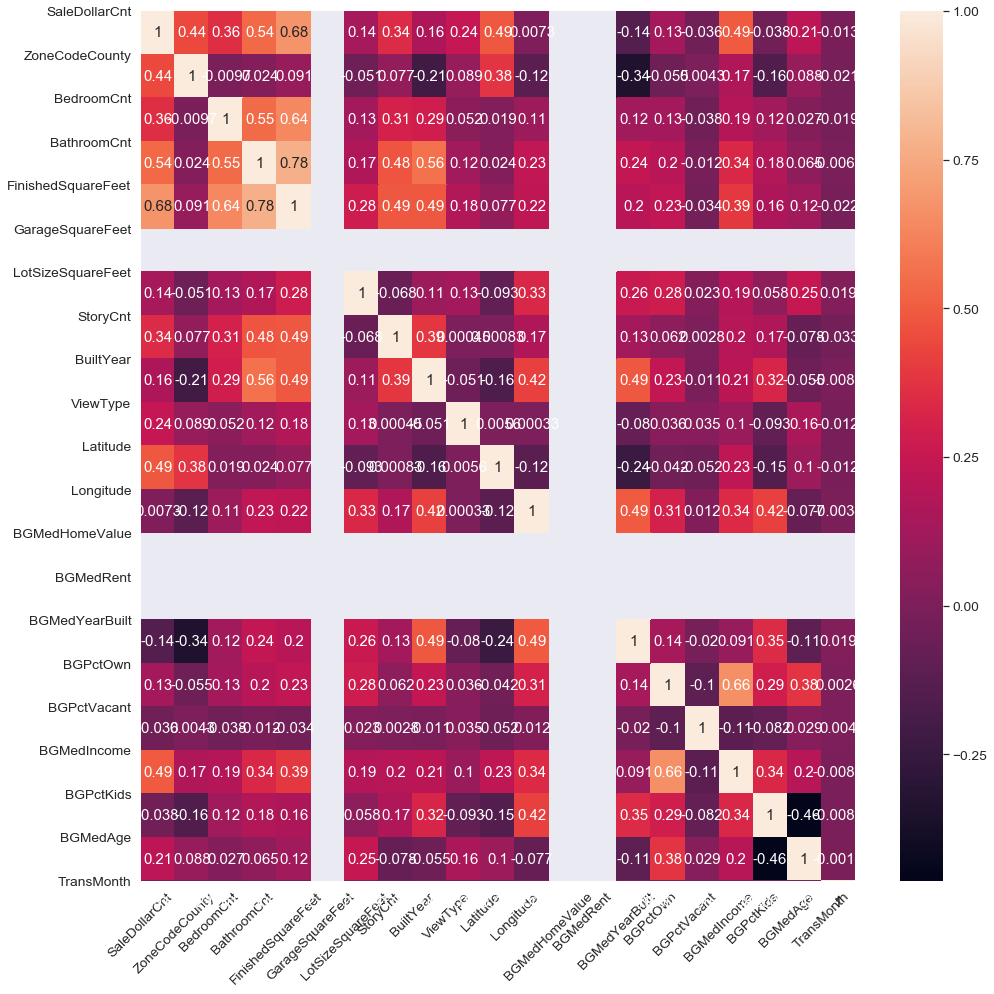

In [1884]:
# Creating correlation matrix
corr_matrix = dataset.corr()

fig= plt.figure(figsize=(16,16))
sns.set(font_scale=1.25)
sns.heatmap(corr_matrix, cbar=True, annot=True)
plt.xticks(range(len(dataset.columns)), dataset.columns, rotation=45)
plt.yticks(range(len(dataset.columns)), dataset.columns)
plt.show()

Correaltion matrix shows the linear correlation between all the columns. But we are interested in finding the correlation of variables with home prices('SaleDollarCnt')

In [1885]:
# check correlation of 'SaleDollarCnt with different variables
corr_matrix['SaleDollarCnt'].sort_values(ascending = False)

# correlation with Home Price
saleprice_cor = abs(cor['SaleDollarCnt'])

#Selecting highly correlated features
# Setting the threshold as 0.45 since some values are quite close to 0.5
significant_features = saleprice_cor[saleprice_cor > 0.45]
significant_features

SaleDollarCnt        1.000
BathroomCnt          0.536
FinishedSquareFeet   0.668
Latitude             0.496
BGMedIncome          0.491
Name: SaleDollarCnt, dtype: float64

In [1886]:
# Check correlation within these varaibles
print(dataset[['BathroomCnt','FinishedSquareFeet']].corr())
print(dataset[['BathroomCnt','BGMedIncome']].corr())
print(dataset[["FinishedSquareFeet","BGMedIncome"]].corr())

                    BathroomCnt  FinishedSquareFeet
BathroomCnt               1.000               0.777
FinishedSquareFeet        0.777               1.000
             BathroomCnt  BGMedIncome
BathroomCnt        1.000        0.336
BGMedIncome        0.336        1.000
                    FinishedSquareFeet  BGMedIncome
FinishedSquareFeet               1.000        0.394
BGMedIncome                      0.394        1.000


Number of bathrooms are highly correlated to finished square feet(0.777). Hence, I would select only one variable and drop the other. We will keep FinishedSquareFeet since its correlation with Sale Price is higher than that of BathroomCnt. 
Since Pearson correlation tells us about only the linear relationship, I will explore other embedded methods like Lasso. 

### Feature selection with Lasso
The lasso will penalize the coeffcients of less significant features to absolute zero. It will fetch the relevant features based on the value of hyperparameter.

In [1887]:
#Feature selection with Lasso
select_feature = SelectFromModel(Lasso(alpha=0.006, random_state=0))
select_feature.fit(X_train, y_train)

SelectFromModel(estimator=Lasso(alpha=0.006, copy_X=True, fit_intercept=True,
                                max_iter=1000, normalize=False, positive=False,
                                precompute=False, random_state=0,
                                selection='cyclic', tol=0.0001,
                                warm_start=False),
                max_features=None, norm_order=1, prefit=False, threshold=None)

In [1888]:
# Get selected features
selected_features = X_train.columns[(select_feature.get_support())]
selected_features

Index(['ZoneCodeCounty', 'FinishedSquareFeet', 'StoryCnt', 'ViewType',
       'Latitude', 'BGMedYearBuilt', 'BGMedIncome'],
      dtype='object')

The selected features are 'ZoneCodeCounty', 'FinishedSquareFeet', 'StoryCnt', 'ViewType','Latitude', 'BGMedYearBuilt', 'BGMedIncome'

In [1889]:
print("No of features selected are:", len(selected_features))

No of features selected are: 7


In [1890]:
# subset features in training data
X_train=X_train[selected_features]
X_train.head()

,ZoneCodeCounty,FinishedSquareFeet,StoryCnt,ViewType,Latitude,BGMedYearBuilt,BGMedIncome
0,0.000,0.513,0.000,0.000,0.230,0.545,0.337
1,0.500,0.548,0.000,0.320,0.460,0.455,0.424
2,0.778,0.545,0.000,0.000,0.574,0.106,0.443
3,0.944,0.591,0.000,0.320,0.325,0.576,0.348
4,0.500,0.487,0.500,0.316,0.453,0.500,0.495


In [1892]:
# subset featutes in test data
X_test = X_test[selected_features]
X_test.head()

,ZoneCodeCounty,FinishedSquareFeet,StoryCnt,ViewType,Latitude,BGMedYearBuilt,BGMedIncome
0,1.000,0.872,0.000,0.317,0.914,0.258,0.780
1,1.000,0.592,0.000,0.317,0.916,0.258,0.780
2,0.737,0.458,0.500,0.000,0.924,0.258,0.780
3,0.737,0.274,0.000,0.000,0.919,0.258,0.780
4,1.000,0.655,0.000,0.333,0.923,0.258,0.780


I have selected the relevant features in training and test data. Lets move forward to model building.

# Model Building

### I will start the model building with linear regression model and consider it as a basline. After that I will explore more sophisticated methods like Random Forest model.


In [1893]:
# preparing kfold cross validation
kfold = model_selection.KFold(n_splits=10, random_state=100, shuffle=False)

In [1897]:
# function for cross-validation
def crossValidation(model):
    results_kfold = model_selection.cross_val_score(model, X_train, y_train, scoring='r2')
    return results_kfold.mean()

This crossValidation function will take model as the input and will split the model in train and validation set and validate house prices against each training set.It returns mean R-squared value. Higher the R-squared value, better the model fits the data.

I am using R-squared as a criteria to comapare my regression models because I am using same dependent variables and the same estimation period. In this case, as R-squared goes up, Standard Error(SE) of the regression goes down. Hence, regression model with highest R-squared will have the lowest standard error.

In [1899]:
# Linear Regression Model
linearmodel = LinearRegression()
r_squared = crossValidation(linearmodel)
r_squared

0.7410352030794009

The mean R-squared value in linear raegression model(after cross validation) is 0.741

The linear model focusses on the linear relationship between dependent and independent variables.To improve the model efficiency, I am moving towards more sophisticated models like random forest model. Random forest model is robust to non-linear and unbalanced data. Moreover, it has low bias as compared to linear model.

In [1900]:
# random forest model
rfcmodel = RandomForestRegressor()
r_squared = crossValidation(rfcmodel)
r_squared

0.8158750529062729

The mean R-squared value in random forest model improved to 0.815 as compared to 0.741 in linear regression model.
To further improve the model performance, I will apply ensemble methods like XGBoost(Extreme Gradient Boosting)

In [1901]:
warnings.filterwarnings('ignore', module='sklearn', lineno=152)
xgbmodel = xgb.XGBRegressor()
r_squared = crossValidation(xgbmodel)
r_squared

[22:27:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:27:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:27:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.831662655867453

The mean R-squared value in random forest model improved to 0.831.

# Predicting home prices

As I got the highest R-squared value in XGBoost model,I will use it to predict home prices.

In [1903]:
# Predicting home prices using xgbmodel
xgbmodel.fit(X_train, y_train)

# Store prices in a data frame after converting it back from log normal form
result["SaleDollarCnt"] = pd.DataFrame(np.exp(xgbmodel.predict(X_test)))

result.to_csv("HomePrice.csv", index=False)

[22:28:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


I have stored the predicted home prices in HomePrice.csv.

### Potential areas of improvement

1. I could have calculated metrics like difference between year built and 2015 and checked it's relation with home price. Usually, old homes have less prices. Again, there is an assumption that homes are not remodeled.
2. I could have used other methods for feature selection like wrapper methods(Forward Selection and Backward Elimination) and other embedded methods like Random Forest.
3. Other metrics like RMSE might have been useful to compare the accuracy of my models
4. I could have used the same measure as recommended by Zillow to measure the accuracy of model
5. Randomized search on hyper parameters of models
6. I could have tried other models like Lasso regression model
7. I could have imputed missing values of BGMedYearBuilt by using models like KNN 
8. Reduce memory consumption of our dataframe by reducing int and float columns to int8 and reducing memory of `float64` type columns to `float32` type columns

### Next steps

1. I will experiment with the ideas mentioned in 'Potential areas of improvement' and try to improve the model efficiency pf models.
2. Then I will deploy the model and fine tune it to increase the accuracy of predictions.

### The End